In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ptitprince as pt
from scipy.stats import halfnorm

In [246]:
country = 'Saint Lucia'
household_survey = pd.read_csv(f'../data/processed/household_survey/{country}/{country}.csv')

## _assign_savings()

It seems that what we do here is define a multiplier `m` for the product of `aaexp` and `saving_rate`. This multiplier has a (random) mean with uniform distribution from 0 to 5 scale=2.5 and normally distributed. On top of that we clip it between 0 and 1.     

In [247]:
saving_rate = 0.02385
df = household_survey.eval(f'aeexp*{saving_rate}').to_frame()
df.columns = ['aeexp*saving_rate']

loc = np.random.uniform(0, 5)
scale = 2.5
size = df.shape[0]
clip_min = 0 
clip_max = 1
m = np.random.normal(loc, scale, size).round(2).clip(min=clip_min, max=clip_max)
df['aesav'] = df['aeexp*saving_rate'] * m

In [248]:
# Let's sample it for a couple of times
low = 0
high = 5
scale = 2.5
size = df.shape[0]
clip_min = 0 
clip_max = 1

clipped = []
unclipped = []
n = 1000
for i in range(0,n):
    loc = np.random.uniform(low, high)
    m = np.random.normal(loc, scale, size).round(2) # .clip(min=clip_min, max=clip_max)
    unclipped.append(m)
    clipped.append(m.clip(min=clip_min, max=clip_max))
clipped = pd.DataFrame(clipped).T
unclipped = pd.DataFrame(unclipped).T

The resulting distribution is skewed. It has a much number of observations around 0 and 1.

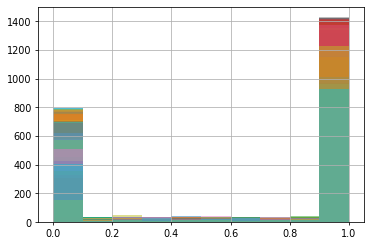

In [249]:
fig, ax = plt.subplots()
for i in range(n):
    clipped.iloc[:,i].hist(ax=ax, label='clipped', alpha=0.5, bins=10)

In [250]:
value_counts = clipped.apply(lambda x: x.value_counts(), axis=0).mean(axis=1).sort_values()

In [251]:
value_counts / value_counts.sum()

0.20    0.001249
0.06    0.001274
0.01    0.001282
0.03    0.001307
0.15    0.001308
          ...   
0.66    0.001473
0.97    0.001495
0.94    0.001526
0.00    0.192346
1.00    0.670192
Length: 101, dtype: float64

Thus, most of the values (**66%**) won't be changed, other **20%** turned to 0 and the rest (**14%**) will become smaller. As a result we have quite some difference between `aesav` and `aeexp`*`saving_rate`. Let's see how this affects the distribution of the two variables.

In [252]:
df['mean_sample'] = df['aeexp*saving_rate'] * clipped.mean(axis=1)

In [254]:
(df['aesav'] - df['mean_sample']).describe()

count    1493.000000
mean      -39.573844
std       282.004671
min     -3649.975895
25%      -136.959981
50%        33.545311
75%        78.864000
max      3859.017915
dtype: float64

In [255]:
melted = pd.melt(df, value_vars=['aeexp*saving_rate', 'aesav', 'mean_sample'], var_name='variable', value_name='value')

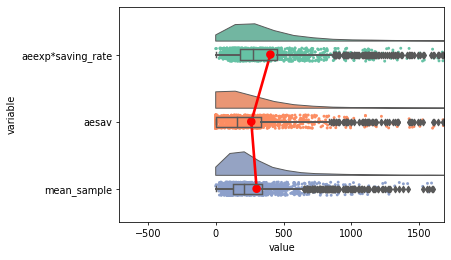

In [256]:
ax = pt.RainCloud(x='variable', y='value', data=melted, palette='Set2', 
             bw=0.2, width_viol=.7, orient='h', pointplot=True, cut=0);
ax.set_xlim(right=melted['value'].quantile(0.99));

## _set_vulnerability()

In [264]:
df = household_survey['v_init'].to_frame()

In [274]:
# Let's take a look at a single sample
low = 0.6
high = 1.4
df['v'] = df['v_init'] * np.random.uniform(low, high, df.shape[0])
threshold = 0.95
df.loc[df['v'] > threshold, 'v'] = threshold

# And now let's take average over 1000 samples
sample = []
n = 10000
for i in range(n):
    sample.append(np.random.uniform(low, high, df.shape[0]))
sample = pd.DataFrame(sample)
mean_sample = sample.mean(axis=0)
df['mean_sample'] = df['v_init'] * mean_sample
df.loc[df['mean_sample'] > threshold, 'mean_sample'] = threshold

In [272]:
df

,v_init,v,mean_sample
0,0.500,0.518279,0.522712
1,0.550,0.662747,0.557595
2,0.425,0.591631,0.417008
3,0.425,0.373528,0.423322
4,0.500,0.661558,0.481700
...,...,...,...
1488,0.500,0.459605,0.508049
1489,0.550,0.515928,0.556573
1490,0.425,0.501930,0.415593
1491,0.600,0.408302,0.561977


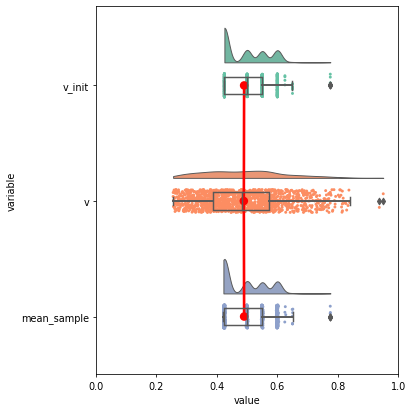

In [275]:
plt.figure(figsize=(6,6))
melted = pd.melt(df, value_vars=['v_init', 'v', 'mean_sample'], var_name='variable', value_name='value')
ax = pt.RainCloud(x='variable', y='value', data=melted, palette='Set2', 
             bw=0.2, width_viol=0.6, orient='h', pointplot=True, cut=0)
ax.set_xlim(0, 1)
plt.tight_layout()